# Extensions to Linear Models - Lab

## Introduction

In this lab, you'll practice many concepts you have learned so far, from adding interactions and polynomials to your model to AIC and BIC!

## Summary

You will be able to:
- Build a linear regression model with interactions and polynomial features 
- Use AIC and BIC to select the best value for the regularization parameter 


## Let's get started!

Import all the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures

Load the data.

In [2]:
df = pd.read_csv("ames.csv")

In [3]:
df = df[['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd',
         'GarageArea', 'Fireplaces', 'SalePrice']]

## Look at a baseline housing data model

Above, we imported the Ames housing data and grabbed a subset of the data to use in this analysis.

Next steps:

- Split the data into target (`y`) and predictors (`X`) -- ensure these both are DataFrames 
- Scale all the predictors using `scale`. Convert these scaled features into a DataFrame 
- Build at a baseline model using *scaled variables* as predictors. Use 5-fold cross-validation (set `random_state` to 1) and use the $R^2$ score to evaluate the model 

In [51]:
# Your code here
y = df[['SalePrice']]
X = df.drop('SalePrice', axis=1)
type(y), type(X)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [52]:
X_scaled = scale(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled.head(2)

,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,Fireplaces
0,-0.207142,0.651479,-0.517200,-0.459303,-0.793434,1.161852,0.370333,0.912210,0.351000,-0.951226
1,-0.091886,-0.071836,2.179628,0.466465,0.257140,-0.795163,-0.482512,-0.318683,-0.060731,0.600495


In [56]:
linreg = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = cross_val_score(linreg, X_scaled, y, cv=cv).mean()
baseline

0.7524751004088887

## Include interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Next, evaluate that model using 5-fold cross-validation and store the $R^2$ to compare it with the baseline model.

Print the 7 most important interactions.

In [57]:
# Your code here
model = LinearRegression()

tracker = {}

for a, b in combinations(X, 2):
    
    # copy and add the current interaction
    X_int = X.copy()
    X_int[a+'_'+b] = X_int[a] * X_int[b]
    
    # evaluate the model
    cvs = cross_val_score(linreg, X_int, y, cv=cv).mean()
    
    tracker[a+'_'+b] = [cvs]

In [58]:
interactions = pd.DataFrame(tracker).T.sort_values(by=0, ascending=False)
interactions.head(7)

,0
OverallQual_TotRmsAbvGrd,0.769742
OverallQual_GarageArea,0.763705
OverallQual_2ndFlrSF,0.757779
2ndFlrSF_TotRmsAbvGrd,0.756143
2ndFlrSF_GrLivArea,0.756001
OverallQual_Fireplaces,0.754232
OverallCond_TotalBsmtSF,0.754090


Write code to include the 7 most important interactions in your data set by adding 7 columns. Name the columns "var1_var2", where var1 and var2 are the two variables in the interaction.

In [59]:
interaction_pairs = [x.split('_') for x in list(interactions.index[:7])]
interaction_pairs

[['OverallQual', 'TotRmsAbvGrd'],
 ['OverallQual', 'GarageArea'],
 ['OverallQual', '2ndFlrSF'],
 ['2ndFlrSF', 'TotRmsAbvGrd'],
 ['2ndFlrSF', 'GrLivArea'],
 ['OverallQual', 'Fireplaces'],
 ['OverallCond', 'TotalBsmtSF']]

In [60]:
# Your code here
X_ints = X_scaled.copy()

for a,b in interaction_pairs:
    X_ints[a+'_'+b] = X[a] * X[b]
    
X_ints.head(2)

,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,Fireplaces,OverallQual_TotRmsAbvGrd,OverallQual_GarageArea,OverallQual_2ndFlrSF,2ndFlrSF_TotRmsAbvGrd,2ndFlrSF_GrLivArea,OverallQual_Fireplaces,OverallCond_TotalBsmtSF
0,-0.207142,0.651479,-0.517200,-0.459303,-0.793434,1.161852,0.370333,0.912210,0.351000,-0.951226,56,3836,5978,6832,1460340,0,4280
1,-0.091886,-0.071836,2.179628,0.466465,0.257140,-0.795163,-0.482512,-0.318683,-0.060731,0.600495,36,2760,0,0,0,6,10096


In [61]:
# evaluate the model
cross_val_score(linreg, X_ints, y, cv=cv).mean()

0.7627423479643707

## Include polynomials

Try polynomials of degrees 2, 3, and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of 4, the particular column is raised to the power of 2 and 3 as well in other terms. We only want to include "pure" polynomials, so make sure no interactions are included. We want the result to return a list that contain tuples of the form:

`(var_name, degree, R2)`, so eg. `('OverallQual', 2, 0.781)` 

In [62]:
# Your code here
tracker = []
for col in X_scaled:
    for p in range(2, 5):
        
        X_test = X_scaled.copy()
        
        # PolynomialFeatures will not include an interatcion because we are using it on a single column
        poly = PolynomialFeatures(p, include_bias=False)
        X_transformed = poly.fit_transform(X[[col]])
      
        X_test = pd.concat([X_test.drop(col, axis=1), 
                            pd.DataFrame(X_transformed)], axis=1)
        
        
        # create a model with the interaction
        model = LinearRegression().fit(X_test, y)

        # evaluate the model
        cvs = cross_val_score(model, X_test, y, cv=cv).mean()
        if cvs > baseline: tracker.append((col, p, cvs))

tracker

[('OverallQual', 2, 0.7806086732834392),
 ('OverallQual', 3, 0.7790396103063509),
 ('OverallQual', 4, 0.7791919536787754),
 ('OverallCond', 4, 0.7526157299492837),
 ('2ndFlrSF', 2, 0.7711185948658968),
 ('2ndFlrSF', 3, 0.7753364281415152),
 ('2ndFlrSF', 4, 0.771287076977294),
 ('GrLivArea', 3, 0.7880091923790147),
 ('GrLivArea', 4, 0.8068027730692634),
 ('TotRmsAbvGrd', 3, 0.7525382764131429),
 ('GarageArea', 3, 0.7575678986238662),
 ('GarageArea', 4, 0.7673370306000052)]

For each variable, print out the maximum $R^2$ possible when including Polynomials.

In [63]:
result = pd.DataFrame(tracker, columns=['Feature', 'Poly', 'r2'])
result

,Feature,Poly,r2
0,OverallQual,2,0.780609
1,OverallQual,3,0.779040
2,OverallQual,4,0.779192
3,OverallCond,4,0.752616
4,2ndFlrSF,2,0.771119
5,2ndFlrSF,3,0.775336
6,2ndFlrSF,4,0.771287
7,GrLivArea,3,0.788009
8,GrLivArea,4,0.806803
9,TotRmsAbvGrd,3,0.752538


In [64]:
result.groupby('Feature').max().sort_values(by='r2', ascending=False)

,Poly,r2
Feature,,
GrLivArea,4,0.806803
OverallQual,4,0.780609
2ndFlrSF,4,0.775336
GarageArea,4,0.767337
OverallCond,4,0.752616
TotRmsAbvGrd,3,0.752538


Which two variables seem to benefit most from adding polynomial terms?

Add Polynomials for the two features that seem to benefit the most, as in have the best $R^2$ compared to the baseline model. For each of the two features, raise to the Polynomial that generates the best result. Make sure to start from the data set `df_inter` so the final data set has both interactions and polynomials in the model.

In [69]:
df_inter = X_ints.copy()
for col in ['OverallQual', 'GrLivArea']:
    poly = PolynomialFeatures(4, include_bias=False)
    X_transformed = poly.fit_transform(X[[col]])
    colnames= [col, col + '_' + '2',  col + '_' + '3', col + '_' + '4']
    df_inter = pd.concat([df_inter.drop(col, axis=1), pd.DataFrame(X_transformed, columns=colnames)], axis=1)

Check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [70]:
df_inter.head()

,LotArea,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,GarageArea,Fireplaces,OverallQual_TotRmsAbvGrd,OverallQual_GarageArea,...,OverallQual_Fireplaces,OverallCond_TotalBsmtSF,OverallQual,OverallQual_2,OverallQual_3,OverallQual_4,GrLivArea,GrLivArea_2,GrLivArea_3,GrLivArea_4
0,-0.207142,-0.517200,-0.459303,-0.793434,1.161852,0.912210,0.351000,-0.951226,56,3836,...,0,4280,7.0,49.0,343.0,2401.0,1710.0,2924100.0,5.000211e+09,8.550361e+12
1,-0.091886,2.179628,0.466465,0.257140,-0.795163,-0.318683,-0.060731,0.600495,36,2760,...,6,10096,6.0,36.0,216.0,1296.0,1262.0,1592644.0,2.009917e+09,2.536515e+12
2,0.073480,-0.517200,-0.313369,-0.627826,1.189351,-0.318683,0.631726,0.600495,42,4256,...,7,4600,7.0,49.0,343.0,2401.0,1786.0,3189796.0,5.696976e+09,1.017480e+13
3,-0.096897,-0.517200,-0.687324,-0.521734,0.937276,0.296763,0.790804,0.600495,49,4494,...,7,3780,7.0,49.0,343.0,2401.0,1717.0,2948089.0,5.061869e+09,8.691229e+12
4,0.375148,-0.517200,0.199680,-0.045611,1.617877,1.527656,1.698485,0.600495,72,6688,...,8,5725,8.0,64.0,512.0,4096.0,2198.0,4831204.0,1.061899e+10,2.334053e+13


## Full model R-squared

Check out the $R^2$ of the full model.

In [74]:
# Your code here

# evaluate the model
full_model = cross_val_score(model, df_inter, y, cv=cv).mean()
full_model

0.8245951965693232

## Find the best Lasso regularization parameter

You learned that when using Lasso regularization, your coefficients shrink to 0 when using a higher regularization parameter. Now the question is which value we should choose for the regularization parameter. 

This is where the AIC and BIC come in handy! We'll use both criteria in what follows and perform cross-validation to select an optimal value of the regularization parameter $alpha$ of the Lasso estimator.

Read the page here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html and create a similar plot as the first one listed on the page. 

In [18]:
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV, LassoLarsIC

Text(0.5, 1.0, 'Information-criterion for model selection')

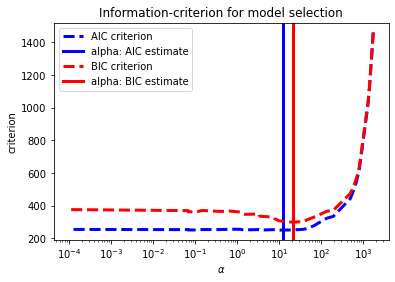

In [78]:
# Your code here 

# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4

# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
#t1 = time.time()
model_bic.fit(df_inter, y)
#t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(df_inter, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')


plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection')

## Analyze the final result

Finally, use the best value for the regularization parameter according to AIC and BIC, and compare $R^2$ and RMSE using train-test split. Compare with the baseline model.

Remember, you can find the Root Mean Squared Error (RMSE) by setting `squared=False` inside the function (see [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)), and the RMSE returns values that are in the same units as our target - so we can see how far off our predicted sale prices are in dollars.

In [20]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

In [80]:
# Split X_scaled and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)

# Code for baseline model
linreg_all = LinearRegression()
linreg_all.fit(X_train, y_train)

# Print R-Squared and RMSE
print('Train R2', linreg_all.score(X_train, y_train))
print('Test  R2', linreg_all.score(X_test, y_test))
print('Train RMSE', mean_squared_error(y_train, linreg_all.predict(X_train), squared=False))
print('Test RMSE', mean_squared_error(y_test, linreg_all.predict(X_test), squared=False))

Train R2 0.7478270652928448
Test  R2 0.8120708166668684
Train RMSE 39424.15590381302
Test RMSE 35519.17035590487


In [82]:
# Split df_inter and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(df_inter, y, random_state=1)

# Code for lasso with alpha from AIC
lasso = Lasso(alpha = model_aic.alpha_)
lasso.fit(X_train, y_train)

# Print R-Squared and RMSE
print('Train R2', lasso.score(X_train, y_train))
print('Test  R2', lasso.score(X_test, y_test))
print('Train RMSE', mean_squared_error(y_train, lasso.predict(X_train), squared=False))
print('Test RMSE', mean_squared_error(y_test, lasso.predict(X_test), squared=False))

Train R2 0.8446719513749287
Test  R2 0.8657639723822621
Train RMSE 30941.268206491884
Test RMSE 30019.27821179212


In [83]:
# Code for lasso with alpha from BIC
lasso = Lasso(alpha = model_bic.alpha_)
lasso.fit(X_train, y_train)

# Print R-Squared and RMSE
print('Train R2', lasso.score(X_train, y_train))
print('Test  R2', lasso.score(X_test, y_test))
print('Train RMSE', mean_squared_error(y_train, lasso.predict(X_train), squared=False))
print('Test RMSE', mean_squared_error(y_test, lasso.predict(X_test), squared=False))

Train R2 0.8446489822922876
Test  R2 0.8660430147326889
Train RMSE 30943.5558367085
Test RMSE 29988.060781354492


## Level up (Optional)

### Create a Lasso path

From this section, you know that when using Lasso, more parameters shrink to zero as your regularization parameter goes up. In Scikit-learn there is a function `lasso_path()` which visualizes the shrinkage of the coefficients while $alpha$ changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

In [106]:
from sklearn.linear_model import lasso_path, enet_path

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X_train, y_train['SalePrice'], eps=eps, positive=True, fit_intercept=False)


Computing regularization path using the lasso...
Computing regularization path using the positive lasso...


In [105]:
y_train['SalePrice'].values

array([307000, 223500, 145000, ..., 127000,  89500,  81000])

In [107]:
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X_train, y_train, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X_train, y_train['SalePrice'], eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


(100, 23)


(-18.678199900068382,
 -16.040465890529138,
 -9.080709362073362e-11,
 1.9069489660354057e-09)

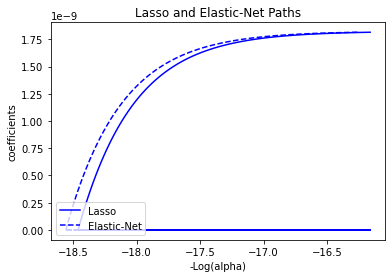

In [114]:
from itertools import cycle

plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    print(coef_l.T.shape)
    l1 = plt.plot(neg_log_alphas_lasso, coef_l.T, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e.T, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')

### AIC and BIC for subset selection
This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Ames housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

## Summary

Congratulations! You now know how to create better linear models and how to use AIC and BIC for both feature selection and to optimize your regularization parameter when performing Ridge and Lasso. 